In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, plot_roc_curve, plot_confusion_matrix, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 

In [ ]:
# Read in the Data
dat = pd.read_excel('default_cc.xls')

In [ ]:
dat.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
#Check for data types by column
dat.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [ ]:
#Data Pre-Processing
#Creating a calculated field to find Percentage of bill amount paid
dat['PERCENTPAY_1'] = round(dat['PAY_AMT1']/dat['BILL_AMT1'], 2)
dat['PERCENTPAY_2'] = round(dat['PAY_AMT2']/dat['BILL_AMT2'], 2)
dat['PERCENTPAY_3'] = round(dat['PAY_AMT3']/dat['BILL_AMT3'], 2)
dat['PERCENTPAY_4'] = round(dat['PAY_AMT4']/dat['BILL_AMT4'], 2)
dat['PERCENTPAY_5'] = round(dat['PAY_AMT5']/dat['BILL_AMT5'], 2)
dat['PERCENTPAY_6'] = round(dat['PAY_AMT6']/dat['BILL_AMT6'], 2)

dat = dat.rename(columns = {'default payment next month': 'default'})

dat = dat.astype({'SEX': 'category', 'EDUCATION': 'category', 'MARRIAGE': 'category', 'PAY_0': 'category', 'PAY_2': 'category', 'PAY_3': 'category',
                 'PAY_4': 'category', 'PAY_5': 'category', 'PAY_6': 'category', 'default': 'category'})

dat.dtypes
dat.shape

(30000, 31)

In [ ]:
#Filling all NA values with 1 as PERCENTPAY_X variable is 100% if BILL_AMTX is 0

dat = dat.replace([np.inf, -np.inf], np.nan)
values = {'PERCENTPAY_1': 1, 'PERCENTPAY_2': 1, 'PERCENTPAY_3': 1, 'PERCENTPAY_4': 1, 'PERCENTPAY_5': 1, 'PERCENTPAY_6': 1}
dat = dat.fillna(value=values)
dat.dtypes

ID                 int64
LIMIT_BAL          int64
SEX             category
EDUCATION       category
MARRIAGE        category
AGE                int64
PAY_0           category
PAY_2           category
PAY_3           category
PAY_4           category
PAY_5           category
PAY_6           category
BILL_AMT1          int64
BILL_AMT2          int64
BILL_AMT3          int64
BILL_AMT4          int64
BILL_AMT5          int64
BILL_AMT6          int64
PAY_AMT1           int64
PAY_AMT2           int64
PAY_AMT3           int64
PAY_AMT4           int64
PAY_AMT5           int64
PAY_AMT6           int64
default         category
PERCENTPAY_1     float64
PERCENTPAY_2     float64
PERCENTPAY_3     float64
PERCENTPAY_4     float64
PERCENTPAY_5     float64
PERCENTPAY_6     float64
dtype: object

In [ ]:
round(1 - len(dat.dropna())/len(dat), 3)

0.0

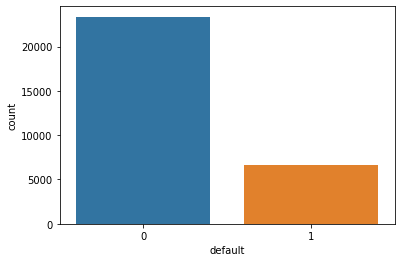

In [40]:
round(dat.groupby('default').size()/len(dat), 3)
sns.countplot(x = 'default', 
              data = dat)

In [42]:
display(dat.groupby('default').size())

default
0    23364
1     6636
dtype: int64

In [ ]:
#Calculate proportion of credit default by age, sex, education and marital status
plotDat = (dat.
           groupby(['AGE', 'SEX', 'EDUCATION', 'MARRIAGE']).
           apply(lambda x: len(x.default[x.default == 1])/len(x.default)).
           reset_index().
           rename(columns = {0: 'proportionDefaulted'})
          )
plotDat.sample(5)

,AGE,SEX,EDUCATION,MARRIAGE,proportionDefaulted
289,34,1,2,3,0.250000
212,30,2,4,2,0.000000
243,32,1,2,3,0.000000
4,21,2,1,2,0.142857
51,24,1,1,2,0.325000


<Figure size 1440x720 with 0 Axes>

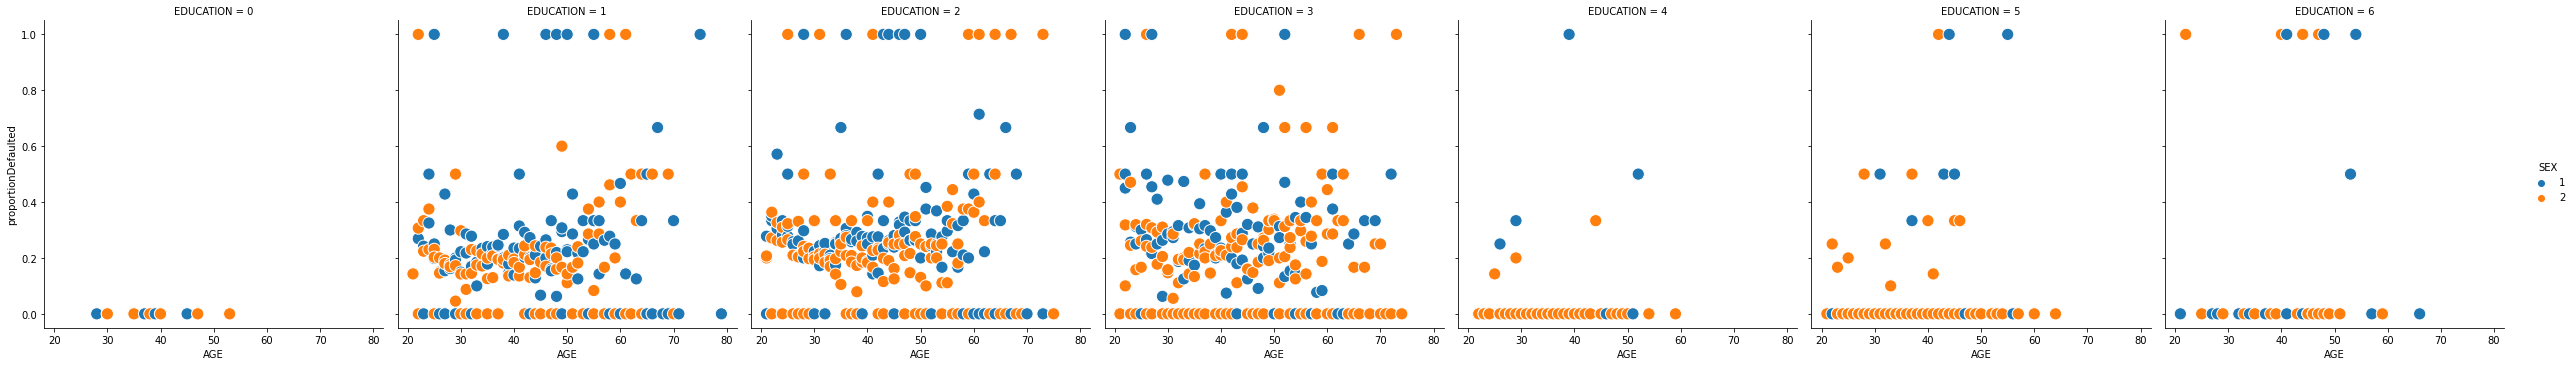

In [ ]:
# Visualizing credit default proportion with respect to age and education level
plt.figure(figsize = (20, 10));

sns.relplot(
    x = 'AGE',
    y = 'proportionDefaulted',
    s = 150,
    hue = 'SEX',
    col = 'EDUCATION',
    kind = 'scatter',
    data = plotDat);

In [ ]:
# Data processing for proportion of credit default with respect to marital status
plotDat = dat.groupby(['MARRIAGE', 'default'], as_index=False).size()
plotDat = plotDat.pivot(index = 'MARRIAGE', columns = ['default'], values = 'size')
plotDat = plotDat.rename_axis(None).rename_axis(None, axis=1)
plotDat.columns = pd.Index(list(plotDat.columns))
plotDat = plotDat.reset_index(drop=True)
plotDat[2] = plotDat[1]/(plotDat[0]+plotDat[1])
plotDat = plotDat.reset_index()
plotDat = plotDat.rename(columns = { 'index' : 'Marriage', 0 : 'nonDefault', 1 : 'default', 2: 'proportion'})
plotDat = plotDat[1:4]
plotDat

,Marriage,nonDefault,default,proportion
1,1,10453,3206,0.234717
2,2,12623,3341,0.209283
3,3,239,84,0.260062


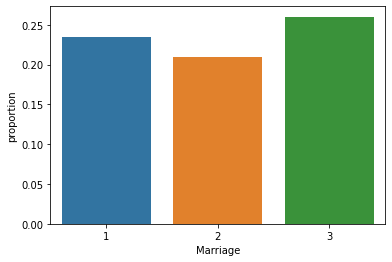

In [ ]:
# Visualizing proportion of credit defaults by marital status
sns.barplot(
  x = 'Marriage',
  y = 'proportion',
  data = plotDat
)

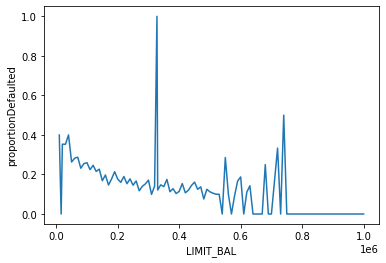

In [ ]:
# Visualizing Limit Balance  
plotDat = (dat.groupby(['LIMIT_BAL']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'}))

plotDat.sample(5)

sns.lineplot(
    x = 'LIMIT_BAL',
    y = 'proportionDefaulted',
    data = plotDat);

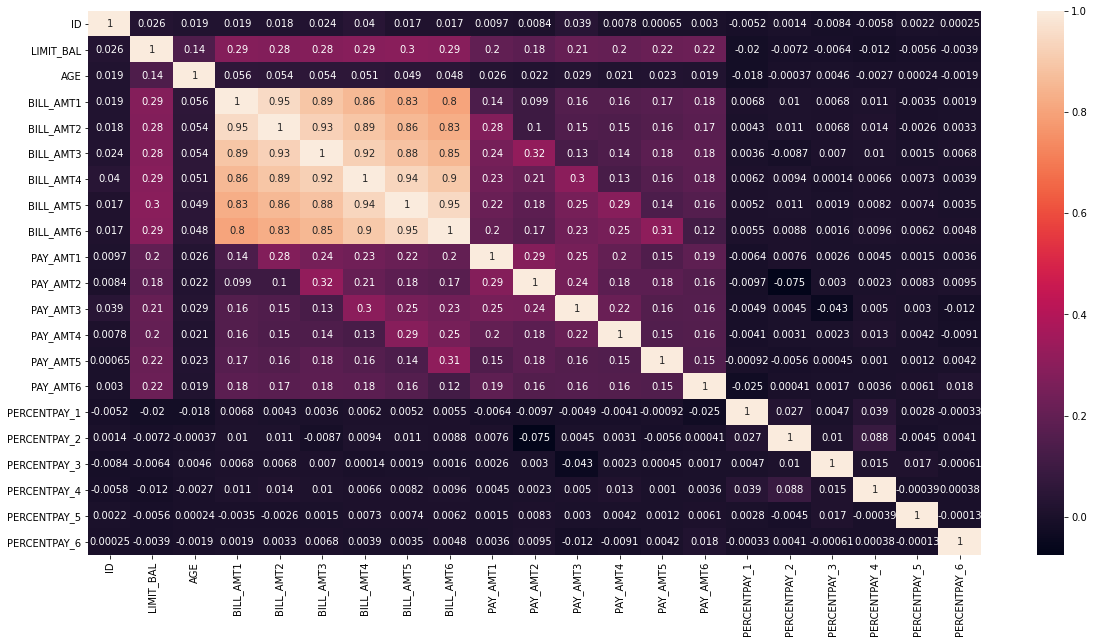

In [ ]:
# Visualizing correlation between variables
plt.figure(figsize = (20, 10))
corrMatrix = dat.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# three main effects

#mod1 = smf.glm(formula = 'default ~ (PERCENTPAY_1 + PERCENTPAY_2 + PERCENTPAY_3 + PERCENTPAY_4 + PERCENTPAY_5 + PERCENTPAY_6)'   
 #                , data = dat, family = sm.families.Binomial()).fit();

#mod2 = smf.glm(formula = 'default ~ (BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)'   
#                 , data = dat, family = sm.families.Binomial()).fit();

mod3 = smf.glm(formula = 'default ~ LIMIT_BAL + SEX + EDUCATION + MARRIAGE + AGE'   
                 , data = dat, family = sm.families.Binomial()).fit();


In [ ]:
#Identifying the best model
models = pd.DataFrame({
    'models': ['mod1', 'mod2', 'mod3'],
    'df': [mod1.df_model, mod2.df_model, mod3.df_model],
    'AIC': [mod1.aic, mod2.aic, mod3.aic]
})

models['deltaAIC'] = models.AIC - min(models.AIC)

models.sort_values('AIC')

,models,df,AIC,deltaAIC
2,mod3,12,30758.837399,0.000000
1,mod2,6,31693.419303,934.581904
0,mod1,6,31713.006412,954.169013


In [ ]:
#Output of the best model
mod3.wald_test_terms()

<class 'statsmodels.stats.contrast.WaldTestResults'>
                 chi2         P>chi2  df constraint
Intercept    0.000003   9.985568e-01              1
SEX         35.110476   3.115204e-09              1
EDUCATION   50.318503   4.058175e-09              6
MARRIAGE    45.828751   6.167462e-10              3
LIMIT_BAL  632.218130  1.645886e-139              1
AGE          4.707225   3.003610e-02              1

In [ ]:
round(mod1.wald_test_terms().table, 3)

,statistic,pvalue,df_constraint
Intercept,8181.241,0.000,1
PERCENTPAY_1,1.605,0.205,1
PERCENTPAY_2,0.953,0.329,1
PERCENTPAY_3,0.359,0.549,1
PERCENTPAY_4,0.799,0.371,1
PERCENTPAY_5,0.031,0.861,1
PERCENTPAY_6,0.402,0.526,1


In [ ]:
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                       
========================================================================================
Dep. Variable:     ['default[0]', 'default[1]']   No. Observations:                30000
Model:                                      GLM   Df Residuals:                    29987
Model Family:                          Binomial   Df Model:                           12
Link Function:                            logit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -15366.
Date:                          Wed, 25 Nov 2020   Deviance:                       30733.
Time:                                  03:46:59   Pearson chi2:                 3.02e+04
No. Iterations:                              21                                         
Covariance Type:                      nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.0171   1.27e+04      0.002      0.999   -2.49e+04     2.5e+04
SEX[T.2]           0.1713      0.029      5.925      0.000       0.115       0.228
EDUCATION[T.1]   -21.1215   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
EDUCATION[T.2]   -21.1555   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
EDUCATION[T.3]   -21.1298   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
EDUCATION[T.4]   -19.7717   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
EDUCATION[T.5]   -19.6948   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
EDUCATION[T.6]   -20.5613   1.27e+04     -0.002      0.999    -2.5e+04    2.49e+04
MARRIAGE[T.1]     -1.2223      0.472     -2.589      0.010      -2.148      -0.297
MARRIAGE[T.2]     -1.0161      0.472     -2.152      0.031      -1.942      -0.091
MARRIAGE[T.3]     -1.0873      0.489     -2.225      0.026      -2.045      -0.129
LIMIT_BAL       3.366e-06   1.34e-07     25.144      0.000     3.1e-06    3.63e-06
AGE               -0.0038      0.002     -2.170      0.030      -0.007      -0.000
==================================================================================
"""

In [ ]:
#Splitting dataset into test and training for Supervised Machine Learning
Train, Test = train_test_split(dat, 
                               stratify = dat.default,
                               test_size = 0.20, 
                               random_state = 345)

display(len(Train),
        len(Test))

display(Test.groupby('default').size())
round(Test.groupby('default').size()/len(Test), 3)

24000

6000

default
0    4673
1    1327
dtype: int64

default
0    0.779
1    0.221
dtype: float64

In [ ]:
#Downsampling data to balance the dataset
np.random.seed(345) # to create reproducible results

maj_class = np.where(Train.default == 0)[0]
min_class = np.where(Train.default == 1)[0]

resample = np.random.choice(maj_class, size = len(min_class), replace = False)

TrainDS = pd.concat([Train.iloc[min_class], Train.iloc[resample]])

TrainDS.shape

(10618, 31)

In [ ]:
display(TrainDS.groupby('default').size())
round(TrainDS.groupby('default').size()/len(TrainDS), 3)

default
0    5309
1    5309
dtype: int64

default
0    0.5
1    0.5
dtype: float64

In [ ]:
round(1 - len(TrainDS.dropna())/len(TrainDS), 3)

0.0

In [ ]:
#Encoding categorical variables
enc = OneHotEncoder(handle_unknown = 'ignore', 
                    sparse = False)

enc_raw_data_train = TrainDS.select_dtypes(['object', 'category']).drop(columns = 'default') 

enc = enc.fit(enc_raw_data_train)

encoded_data_train = pd.DataFrame(enc.transform(enc_raw_data_train))

encoded_data_train.columns = enc.get_feature_names(enc_raw_data_train.columns)
encoded_data_train.index = enc_raw_data_train.index

TrainDS_Enc = pd.concat([TrainDS.drop(enc_raw_data_train.columns, axis = 1), encoded_data_train], axis = 1)

TrainDS_Enc.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,PERCENTPAY_1,PERCENTPAY_2,PERCENTPAY_3,PERCENTPAY_4,PERCENTPAY_5,PERCENTPAY_6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,...,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
1777,1778,40000,43,41094,36554,37568,38314,39141,40231,1611,1625,1371,1444,1765,1283,1,0.04,0.04,0.04,0.04,0.05,0.03,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14351,14352,440000,38,775,1550,775,775,925,775,1551,1,776,926,776,776,1,2.00,0.00,1.00,1.19,0.84,1.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15862,15863,100000,29,73742,75216,82006,84044,84532,80828,2700,8000,4304,3000,0,3000,1,0.04,0.11,0.05,0.04,0.00,0.04,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8361,8362,20000,32,19468,20844,19362,19402,19607,19821,3000,0,850,920,750,300,1,0.15,0.00,0.04,0.05,0.04,0.02,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27589,27590,140000,55,0,0,0,0,0,0,0,0,0,0,0,0,1,1.00,1.00,1.00,1.00,1.00,1.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Removing columns with no Variance
selector = VarianceThreshold()

sel_raw_data_train = TrainDS_Enc.drop(columns = 'default') 

selector = selector.fit(sel_raw_data_train)

selected_data_train = pd.DataFrame(selector.transform(sel_raw_data_train))

selected_data_train.columns = sel_raw_data_train.columns
selected_data_train.index = sel_raw_data_train.index

TrainDS_EncSel = pd.concat([TrainDS_Enc.drop(sel_raw_data_train.columns, axis = 1), selected_data_train], axis = 1)

TrainDS_EncSel.head()

,default,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PERCENTPAY_1,PERCENTPAY_2,PERCENTPAY_3,PERCENTPAY_4,PERCENTPAY_5,PERCENTPAY_6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,...,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
1777,1,1778.0,40000.0,43.0,41094.0,36554.0,37568.0,38314.0,39141.0,40231.0,1611.0,1625.0,1371.0,1444.0,1765.0,1283.0,0.04,0.04,0.04,0.04,0.05,0.03,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14351,1,14352.0,440000.0,38.0,775.0,1550.0,775.0,775.0,925.0,775.0,1551.0,1.0,776.0,926.0,776.0,776.0,2.00,0.00,1.00,1.19,0.84,1.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15862,1,15863.0,100000.0,29.0,73742.0,75216.0,82006.0,84044.0,84532.0,80828.0,2700.0,8000.0,4304.0,3000.0,0.0,3000.0,0.04,0.11,0.05,0.04,0.00,0.04,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8361,1,8362.0,20000.0,32.0,19468.0,20844.0,19362.0,19402.0,19607.0,19821.0,3000.0,0.0,850.0,920.0,750.0,300.0,0.15,0.00,0.04,0.05,0.04,0.02,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27589,1,27590.0,140000.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Scaling the dataset

Scaler = StandardScaler()

scl_raw_data_train = TrainDS_EncSel.drop(columns = 'default') 

Scaler = Scaler.fit(scl_raw_data_train)

scaled_data_train = pd.DataFrame(Scaler.transform(scl_raw_data_train))

scaled_data_train.columns = scl_raw_data_train.columns
scaled_data_train.index = scl_raw_data_train.index

TrainDS_EncSelScl = pd.concat([TrainDS_EncSel.drop(scl_raw_data_train.columns, axis = 1), scaled_data_train], axis = 1)

TrainDS_EncSelScl.head()

,default,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PERCENTPAY_1,PERCENTPAY_2,PERCENTPAY_3,PERCENTPAY_4,PERCENTPAY_5,PERCENTPAY_6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,...,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
1777,1,-1.517164,-0.911019,0.781986,-0.128129,-0.169511,-0.130647,-0.074276,-0.020998,0.021722,-0.240614,-0.216282,-0.183256,-0.200937,-0.182493,-0.206330,0.015081,-0.003487,0.005307,0.000638,0.011524,0.010275,1.196651,-1.196651,-0.016811,-0.713660,-0.955050,2.175606,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,1.174358,-0.410309,-0.428476,...,-0.029126,-0.386823,-0.465942,1.023636,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,-0.455729,0.966469,-0.426010,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,-0.447113,0.933988,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,-0.463695,0.974703,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
14351,1,-0.063350,2.275311,0.253864,-0.668334,-0.652734,-0.662383,-0.649997,-0.635525,-0.633140,-0.245302,-0.324286,-0.216283,-0.237627,-0.255490,-0.238256,0.032473,-0.004043,0.013158,0.012518,0.029478,0.018232,1.196651,-1.196651,-0.016811,-0.713660,-0.955050,2.175606,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,-0.851529,-0.410309,2.333854,...,-0.029126,-0.386823,-0.465942,-0.976910,2.111000,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,2.194287,-1.034695,-0.426010,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,2.236574,-1.070678,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,2.156589,-1.025954,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
15862,1,0.111353,-0.433070,-0.696754,0.309299,0.364210,0.511575,0.627068,0.708905,0.695522,-0.155516,0.207685,-0.020451,-0.090723,-0.312765,-0.098211,0.015081,-0.002514,0.005389,0.000638,0.010387,0.010357,-0.835665,0.835665,-0.016811,-0.713660,1.047066,-0.459642,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,1.174358,-0.410309,-0.428476,...,-0.029126,-0.386823,-0.465942,1.023636,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,-0.455729,-1.034695,2.347364,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,-0.447113,-1.070678,2.559672,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,-0.463695,-1.025954,2.551312,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
8361,1,-0.755918,-1.070336,-0.379881,-0.417880,-0.386384,-0.393762,-0.364322,-0.335112,-0.317028,-0.132074,-0.324352,-0.212176,-0.238052,-0.257409,-0.268230,0.016057,-0.004043,0.005307,0.000741,0.011297,0.010193,1.196651,-1.196651,-0.016811,-0.713660,1.047066,-0.459642,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,1.174358,-0.410309,-0.428476,...,-0.029126,-0.386823,-0.465942,-0.976910,2.111000,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,-0.455729,0.966469,-0.426010,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,-0.447113,0.933988,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,-0.463695,0.974703,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
27589,1,1.467236,-0.114437,2.049477,-0.678718,-0.674131,-0.673583,-0.661883,-0.650399,-0.646003,-0.366502,-0.324352,-0.259358,-0.3

In [ ]:
#encoding test dataset
enc_raw_data_test = Test.select_dtypes(['object', 'category']).drop(columns = 'default') 

encoded_data_test = pd.DataFrame(enc.transform(enc_raw_data_test))

encoded_data_test.columns = enc.get_feature_names(enc_raw_data_test.columns)
encoded_data_test.index = enc_raw_data_test.index

Test_Enc = pd.concat([Test.drop(enc_raw_data_test.columns, axis = 1), encoded_data_test], axis = 1)

Test_Enc.head()

#removing columns with 0 variance in test dataset
sel_raw_data_test = Test_Enc.drop(columns = 'default') 

selected_data_test = pd.DataFrame(selector.transform(sel_raw_data_test))

selected_data_test.columns = sel_raw_data_test.columns
selected_data_test.index = sel_raw_data_test.index

Test_EncSel = pd.concat([Test_Enc.drop(sel_raw_data_test.columns, axis = 1), selected_data_test], axis = 1)

Test_EncSel.head()

#scaling data in test dataset
scl_raw_data_test = Test_EncSel.drop(columns = 'default') 

scaled_data_test = pd.DataFrame(Scaler.transform(scl_raw_data_test))

scaled_data_test.columns = scl_raw_data_test.columns
scaled_data_test.index = scl_raw_data_test.index

Test_EncSelScl = pd.concat([Test_EncSel.drop(scl_raw_data_test.columns, axis = 1), scaled_data_test], axis = 1)

Test_EncSelScl.head()

,default,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PERCENTPAY_1,PERCENTPAY_2,PERCENTPAY_3,PERCENTPAY_4,PERCENTPAY_5,PERCENTPAY_6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,...,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
16635,0,0.200728,0.761804,-0.591130,0.311898,0.801642,1.853177,0.586150,0.338124,-0.183536,2.759208,5.378821,1.691913,-0.003175,0.135989,-0.281580,0.019518,0.007076,0.006616,0.000741,0.012660,0.010029,1.196651,-1.196651,-0.016811,1.401227,-0.955050,-0.459642,-0.05323,-0.082627,-0.035012,-0.037612,-0.926590,0.949655,-0.104639,-0.295932,-0.458439,1.174358,-0.410309,-0.428476,...,-0.029126,-0.386823,-0.465942,1.023636,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,-0.455729,0.966469,-0.42601,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,-0.447113,0.933988,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,-0.463695,0.974703,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
3435,0,-1.325465,1.000779,0.465113,-0.678852,-0.674269,-0.673728,-0.662037,-0.650560,-0.646169,-0.366502,-0.324352,-0.259358,-0.303217,-0.312765,-0.287121,0.014726,-0.004043,0.004980,0.000224,0.010387,0.010029,-0.835665,0.835665,-0.016811,-0.713660,1.047066,-0.459642,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,-0.851529,2.437185,-0.428476,...,-0.029126,2.585163,-0.465942,-0.976910,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,2.500546,-0.455729,-1.034695,-0.42601,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,2.402433,-0.447113,-1.070678,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,2.294408,-0.463695,-1.025954,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
21419,0,0.753857,-0.512728,2.155101,0.118802,0.125138,0.160866,0.189284,0.125413,0.148177,-0.157861,-0.145455,-0.090558,-0.034766,-0.165148,-0.161181,0.015081,-0.003348,0.005389,0.000948,0.011297,0.010357,-0.835665,0.835665,-0.016811,-0.713660,-0.955050,2.175606,-0.05323,-0.082627,-0.035012,-0.037612,1.079227,-1.053014,-0.104639,-0.295932,-0.458439,1.174358,-0.410309,-0.428476,...,-0.029126,-0.386823,-0.465942,1.023636,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,-0.399913,-0.455729,0.966469,-0.42601,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,-0.416245,-0.447113,0.933988,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,-0.435842,-0.463695,0.974703,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
22001,0,0.821148,0.841463,-0.802378,-0.679093,-0.594961,-0.663568,-0.638004,-0.639384,-0.453059,0.083835,-0.277599,-0.172543,-0.254485,0.549536,0.153481,-1.811630,-0.002375,0.023461,0.004770,0.398113,0.014951,-0.835665,0.835665,-0.016811,1.401227,-0.955050,-0.459642,-0.05323,-0.082627,-0.035012,-0.037612,-0.926590,0.949655,-0.104639,3.379159,-0.458439,-0.851529,-0.410309,-0.428476,...,-0.029126,2.585163,-0.465942,-0.976910,-0.473709,-0.110026,-0.061493,-0.032203,-0.033637,-0.043441,-0.009705,2.500546,-0.455729,-1.034695,-0.42601,-0.099938,-0.063767,-0.037612,-0.019413,-0.060717,-0.009705,2.402433,-0.447113,-1.070678,-0.390675,-0.101843,-0.063018,-0.032203,-0.016811,-0.060717,2.294408,-0.463695,-1.025954,-0.391955,-0.097997,-0.054981,-0.025684,-0.035012,-0.054112,-0.009705
1138,0,-1.591045,-0.194095,0.887610,0.781776,0.847930,0.963593,0.890904,0.908414,0.714592,-0.014859,0.008171,-0.037326,0.447598,-0.312765,-0.142290

In [ ]:
# set up data and labels
X_train = TrainDS_EncSelScl.drop(columns = 'default')
y_train = TrainDS_EncSelScl.default

X_test = Test_EncSelScl.drop(columns = 'default')
y_test = Test_EncSelScl.default

y_test.dtypes

CategoricalDtype(categories=[0, 1], ordered=False)

In [ ]:
# set up data and labels
X_train = TrainDS_EncSelScl.drop(columns = 'default')
y_train = TrainDS_EncSelScl.default

X_test = Test_EncSelScl.drop(columns = 'default')
y_test = Test_EncSelScl.default

pos_label = 1

# set up scoring metric
scoring_metric = 'balanced_accuracy'

# set up classifiers and tuning parameters
names = [  'Random Forest','XGBoost','MLPClassifier'] #, 'Linear SVM' 'XGBoost' 'Decision Tree', 'AdaBoost', , 
classifiers = [ #DecisionTreeClassifier(random_state = 345), 
               #AdaBoostClassifier(random_state = 345), 
               RandomForestClassifier(random_state = 345),
               XGBClassifier(random_state = 345),
               MLPClassifier(random_state=345)
               #SVC(random_state = 345, kernel = 'linear', probability = True) #,
              
              ]
param_grids = [#{'max_depth': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}, 
               #{'n_estimators': [100,200,300, 400]}, 
               {'max_depth': [ 8,9, 10], 'max_features': [None, 'sqrt', 'log2'], 'n_estimators': [250,300, 350]}, 
               {'n_estimators': [ 340, 350, 360]},
               {'alpha':[1e-05], 'hidden_layer_sizes': [10,2], 'solver':['lbfgs'], 'max_iter':[1150]}
               #{'C': [0.01,0.05, 0.1, 0.5, 1]}
              ]

# create empty lists for storing outcomes
models = []
preds = []
probs = []
BAs = []
AUCs = []
FPRs = []
TPRs = []
timings = []

# train classifiers and generate test predictions/probabilities
for i, eachClassifier in enumerate(classifiers):
    
    print('Now working on model ', i + 1, ' of ', len(classifiers), ': ', names[i], sep = '')
    
    # define cross-validation/parameter tuning settings
    search = GridSearchCV(eachClassifier, 
                          param_grids[i], 
                          cv = 5, 
                          scoring = scoring_metric,
                          n_jobs = -1) 
    
    model = search.fit(X_train, y_train)
    pred = search.predict(X_test)
    prob = search.predict_proba(X_test)[:, 1]
    
    models.append(model)
    preds.append(pred)
    probs.append(prob)
    
    BAs.append(balanced_accuracy_score(y_test, pred))
    AUCs.append(roc_auc_score(y_test, prob))
    
    FPR, TPR, _ = roc_curve(y_test, prob, pos_label = pos_label)
    
    FPRs.append(FPR)
    TPRs.append(TPR)
    
    timings.append(model.refit_time_)
    
print('Finished!')

Now working on model 1 of 3: Random Forest
Now working on model 2 of 3: XGBoost
Now working on model 3 of 3: MLPClassifier
Finished!


In [ ]:
results = pd.DataFrame({'Classifier': names, 
                        'Balanced Accuracy': BAs, 
                        'AUC': AUCs, 
                        'TPR': TPRs, 
                        'FPR': FPRs, 
                        'Refit Time': timings}).sort_values('AUC', ascending = False)

display(round(results[['Classifier', 'Refit Time', 'Balanced Accuracy', 'AUC']], 3))

,Classifier,Refit Time,Balanced Accuracy,AUC
0,Random Forest,3.395,0.718,0.784
1,XGBoost,7.602,0.709,0.780
2,MLPClassifier,2.690,0.705,0.774


In [ ]:
best_index = results.index[0]
models[best_index].best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=345,
                       verbose=0, warm_start=False)

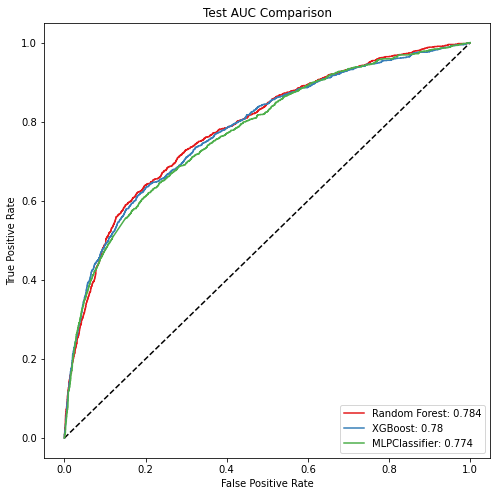

In [38]:
#Plotting ROC curves
def Custom_ROC_Plot (results, X_test, y_test, title):

    fig, ax = plt.subplots(figsize = (8, 8))

    ax.plot(ax.get_xlim(), ax.get_ylim(), ls = '--', c = 'k')
    ax.set(title = title)

    for i in results.index:
        plot_roc_curve(models[i], 
                       X_test, 
                       y_test, 
                       color = cm.Set1(i), 
                       label = results.loc[i, 'Classifier'] + ': ' + str(round(results.loc[i, 'AUC'], 3)), 
                       ax = ax)
        
    return([fig, ax])

fig, ax = Custom_ROC_Plot(results, X_test, y_test, title = 'Test AUC Comparison')

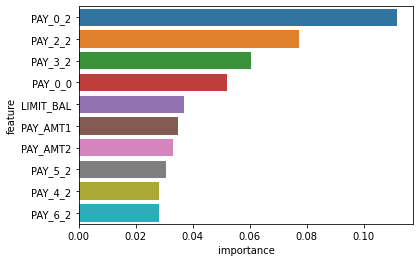

In [ ]:
#Identyfing most important predictors
best_index = results.index[0]
# for models with feature importances
if hasattr(models[best_index].best_estimator_, 'feature_importances_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance': models[best_index].best_estimator_.feature_importances_}).sort_values('importance', ascending = False)
# for models with coefficients (directional)
elif hasattr(models[best_index].best_estimator_, 'coef_'):
    var_imp = pd.DataFrame({
        'feature': X_test.columns, 
        'importance_abs': abs(models[best_index].best_estimator_.coef_[0]), 
        'importance': models[best_index].best_estimator_.coef_[0]}).sort_values('importance_abs', ascending = False)
    
sns.barplot(y = 'feature', 
            x = 'importance', 
            data = var_imp.head(10))

In [ ]:
best_index = results.index[0]
tn, fp, fn, tp = confusion_matrix(y_test, preds[best_index]).ravel()
accuracy = round((tp+tn)/(tp+tn+fp+fn),3)
sensitivity = round(tp/(tp+fn),3)
specificity = round(tn/(tn+fp),3)
baccuracy = round((sensitivity+specificity)/2,3)
print("accuracy: ", accuracy)
print("balanced accuracy: ", baccuracy)
print("sensitivity: ", sensitivity)
print("specificity: ", specificity)

accuracy:  0.759
balanced accuracy:  0.718
sensitivity:  0.644
specificity:  0.792


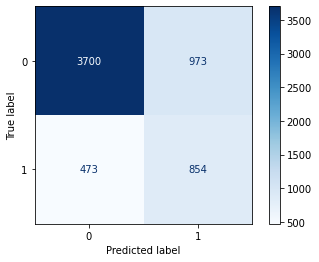

In [ ]:
#plotting confusion matrix
plot_confusion_matrix(models[best_index], 
                      X_test, 
                      y_test,
                      cmap = plt.cm.Blues,
                      values_format = 'd')

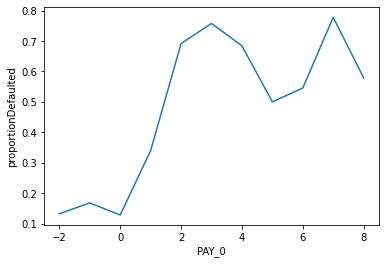

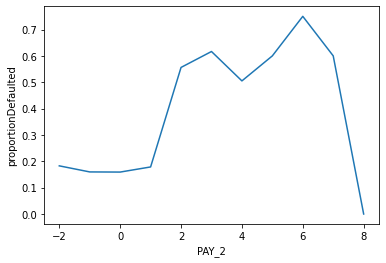

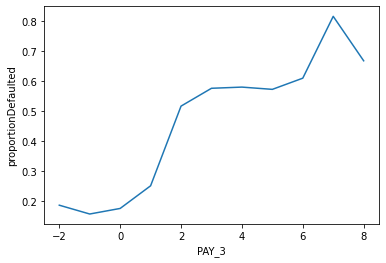

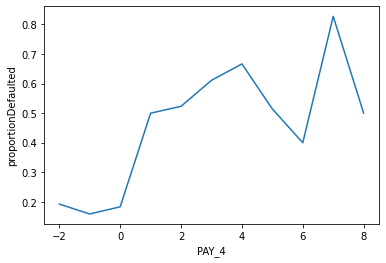

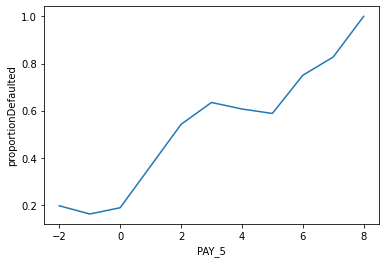

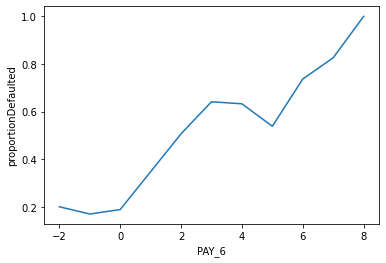

In [ ]:
#Visualizing monthly repayment status(whether repayment occurred on time or delayed) versus credit default rate

plotDat0 = (dat.groupby(['PAY_0']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
          )
plotDat0.sample(5)
plt.figure()
sns.lineplot(
    x = 'PAY_0',
    y = 'proportionDefaulted',
    data = plotDat0)


plotDat2 = (dat.groupby(['PAY_2']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
          )
plt.figure()
sns.lineplot(
    x = 'PAY_2',
    y = 'proportionDefaulted',
    data = plotDat2)

plotDat3 = (dat.groupby(['PAY_3']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
          )
plt.figure()
sns.lineplot(
    x = 'PAY_3',
    y = 'proportionDefaulted',
    data = plotDat3)

plotDat4 = (dat.groupby(['PAY_4']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
          )
plt.figure()
sns.lineplot(
    x = 'PAY_4',
    y = 'proportionDefaulted',
    data = plotDat4)

plotDat5 = (dat.groupby(['PAY_5']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
          )
plt.figure()
sns.lineplot(
    x = 'PAY_5',
    y = 'proportionDefaulted',
    data = plotDat5)

plotDat6 = (dat.groupby(['PAY_6']).apply(lambda x: len(x.default[x.default == 1])/len(x.default)).reset_index().rename(columns = {0: 'proportionDefaulted'})
            )
plt.figure()
sns.lineplot(
    x = 'PAY_6',
    y = 'proportionDefaulted',
    data = plotDat6)